# 1. Load all the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DATA_PATH = "/home/NewYorkTaxiFarePredictions/"
import os
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/NewYorkTaxiFarePredictions/GCP-Coupons-Instructions.rtf
/home/NewYorkTaxiFarePredictions/train.csv
/home/NewYorkTaxiFarePredictions/new-york-city-taxi-fare-prediction.zip
/home/NewYorkTaxiFarePredictions/test.csv
/home/NewYorkTaxiFarePredictions/sample_submission.csv


In [2]:
# from pyspark.sql import SparkSession, functions as F, DataFrame
import pyspark
# spark = SparkSession.builder.getOrCreate()
conf = pyspark.SparkConf()
conf.setMaster('spark://d2e90930a425:7077')
sc = pyspark.SparkContext(conf=conf)
# spark
sc

/usr/local/lib/python3.6/dist-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


<SparkContext master=spark://d2e90930a425:7077 appName=pyspark-shell>

In [3]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
spark

# 2. Load in the data

In [4]:
%%time
sdf_train = spark.read.csv(f'{DATA_PATH}/train.csv', inferSchema=True, header=True)
print((sdf_train.count(), len(sdf_train.columns)))
sdf_train = sdf_train.sample(0.2,123)
print((sdf_train.count(), len(sdf_train.columns)))

(55423856, 8)
(55260, 8)
CPU times: user 20.2 ms, sys: 5.56 ms, total: 25.8 ms
Wall time: 1min 12s


In [5]:
sdf_train.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



## check for missing data, duplicates and weird values

In [6]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = sdf_train.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in sdf_train.columns])
df2.toPandas()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Frequency'>

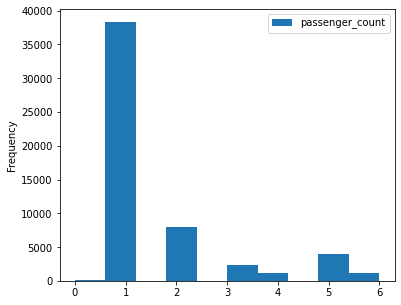

In [7]:
sdf_train.select('passenger_count').limit(200000).toPandas().plot.hist(figsize=(6,5))

<AxesSubplot:xlabel='passenger_count'>

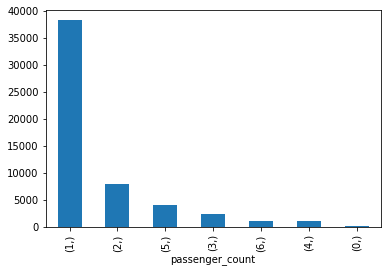

In [8]:
sdf_train.select('passenger_count').limit(200000).toPandas().value_counts().plot.bar()

In [9]:
print((sdf_train.count(), len(sdf_train.columns)))
sdf_train = sdf_train.na.drop("any")
sdf_train = sdf_train.dropDuplicates()
print((sdf_train.count(), len(sdf_train.columns)))

(55260, 8)
(55260, 8)


In [10]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = sdf_train.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in sdf_train.columns])
df2.toPandas()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,0,0,0,0,0,0,0


In [11]:
sdf_train.describe().toPandas()

,summary,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,count,55260,55260,55260,55260,55260,55260,55260,55260
1,mean,None,11.277607129931177,None,-72.39760525501451,39.85972333494272,-72.39670562466237,39.84693589881927,1.6887260224393774
2,stddev,None,9.787154490821832,None,11.850701223940028,6.73282288750667,11.850749273939694,6.363957741642432,1.3177462469383636
3,min,2009-01-01 01:42:29.0000002,-5.0,2009-01-01 01:42:29 UTC,-1182.902908,-73.999845,-1182.890137,-74.005098,0
4,max,2015-06-30 22:34:51.0000002,477.92,2015-06-30 22:34:51 UTC,40.815337,405.25,40.820887,48.152353,6


## removing outliers


using https://www.mapsofworld.com/lat_long/usa-lat-long.html
1. for latitude, filter for between 35 and 45
2. for longitude, filter for between -70 and -80
3. for fare, filter for between 1 to 150
4. passenger count couldn't be more than about 6 

In [12]:
print("Before removing outliers:",(sdf_train.count(), len(sdf_train.columns)))
total_rows = sdf_train.count()

Before removing outliers: (55260, 8)


In [13]:
# latitude
sdf_train = sdf_train.filter(sdf_train["pickup_latitude"]  > 35).filter(sdf_train["pickup_latitude"]  < 45)
sdf_train = sdf_train.filter(sdf_train["dropoff_latitude"]  > 35).filter(sdf_train["dropoff_latitude"]  < 45)

In [14]:
# longitude
sdf_train = sdf_train.filter(sdf_train["pickup_longitude"]  > -80).filter(sdf_train["pickup_longitude"]  < -70)
sdf_train = sdf_train.filter(sdf_train["dropoff_longitude"]  > -80).filter(sdf_train["dropoff_longitude"]  < -70)

In [15]:
# fare_amount
sdf_train = sdf_train.filter(sdf_train["fare_amount"]  > 0).filter(sdf_train["fare_amount"]  < 150)

In [16]:
# passenger_count
sdf_train = sdf_train.filter(sdf_train["passenger_count"]  > 0).filter(sdf_train["passenger_count"]  < 7)

In [17]:
print("After removing outliers:",(sdf_train.count(), len(sdf_train.columns)))

After removing outliers: (53831, 8)


In [18]:
print("rows removed:", sdf_train.count() - total_rows)

rows removed: -1429


In [19]:
sdf_train.describe().toPandas()

,summary,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,count,53831,53831,53831,53831,53831,53831,53831,53831
1,mean,None,11.256136055432687,None,-73.97557827513272,40.75128651810459,-73.97458237661,40.75151686999541,1.6931322100648325
2,stddev,None,9.396255839572671,None,0.039763779117670095,0.0310687834450233,0.038089534791893684,0.035940725939944705,1.3149128987233631
3,min,2009-01-01 01:42:29.0000002,0.04,2009-01-01 01:42:29 UTC,-76.488493,39.605168823685,-76.520118,39.603141808779,1
4,max,2015-06-30 22:34:51.0000002,145.0,2015-06-30 22:34:51 UTC,-73.110473,42.420248,-73.137393,42.424223,6


## random visualisation

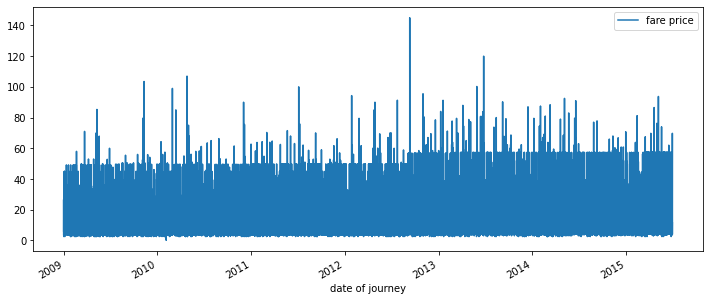

In [20]:
import pandas as pd
pdate = pd.to_datetime(sdf_train.select('pickup_datetime').limit(80000).toPandas()['pickup_datetime'],  format='%Y-%m-%d %H:%M:%S UTC')
pfare = sdf_train.select('fare_amount').limit(80000).toPandas()['fare_amount']
df = pd.DataFrame(columns = ['date of journey', 'fare price'])
df['date of journey'] = pdate
df['fare price'] = pfare
# df['MA'] = df['fare price'].rolling(window=100).mean()
df.sort_values('date of journey', inplace=True)
df.plot('date of journey', 'fare price', figsize=(12,5));

# 3. Data preparation 

we know 1 degree of latitude is 11 kms around about https://www.usgs.gov/faqs/how-much-distance-does-degree-minute-and-second-cover-your-maps

and 1 degree of longitude is 87 kms 

create two new columns which the distance of the journey as the crow flies in kms. 

### make features from the lat & longs

In [21]:
from  pyspark.sql.functions import abs
from  pyspark.sql.functions import sqrt
sdf_train = sdf_train.withColumn('diff_longitude', abs( sdf_train['dropoff_longitude'] - sdf_train['pickup_longitude'] )*87 )
sdf_train = sdf_train.withColumn('diff_latitude', abs( sdf_train['dropoff_latitude'] - sdf_train['pickup_latitude'] )*111 )
sdf_train = sdf_train.withColumn('crow_distance', sqrt((sdf_train['diff_longitude']**2) + (sdf_train['diff_latitude']**2))  )

In [22]:
sdf_train.select('crow_distance').limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
crow_distance,0.939552,0.911767,1.100568,4.401907,2.015608,0.818559,3.889486,6.415202,12.225456,0.935849


In [23]:
sdf_train.select('dropoff_longitude').limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
dropoff_longitude,-73.964351,-73.962065,-73.993904,-73.98648,-74.006528,-73.972447,-73.97688,-73.947088,-73.861265,-74.000228


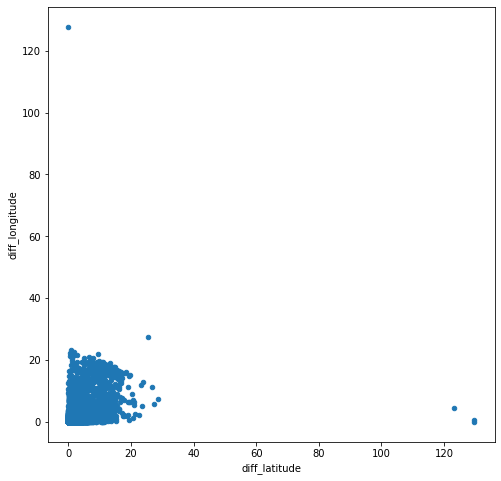

In [24]:
sdf_train.select('diff_latitude','diff_longitude').limit(20000).toPandas().plot.scatter('diff_latitude','diff_longitude',figsize=(8,8));

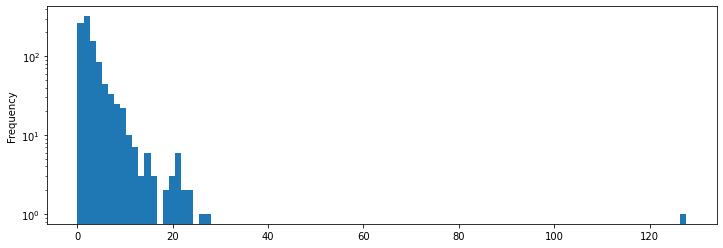

In [25]:
sdf_train.select('crow_distance').limit(10000).toPandas()['crow_distance'].plot.hist(bins=100, log=True, figsize=(12,4));

### adding weekday, year and time features

In [26]:
from pyspark.sql.functions import date_format
sdf_train = sdf_train.withColumn("pickup_weekday", date_format("pickup_datetime", "E"))
sdf_train = sdf_train.withColumn("pickup_hour", date_format("pickup_datetime", "H").cast("int"))
sdf_train = sdf_train.withColumn("pickup_year", date_format("pickup_datetime", "y").cast("int"))
#.withColumn("pickup_hour", date_format("pickup_datetime", "H")).withColumn("pickup_month", date_format("pickup_datetime", "M"))

In [27]:
sdf_train.select('pickup_weekday').limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
pickup_weekday,Mon,Mon,Sat,Sun,Fri,Tue,Wed,Wed,Sun,Thu


In [28]:
sdf_train.select('pickup_datetime').limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
pickup_datetime,2013-03-25 18:31:37 UTC,2013-05-13 17:39:00 UTC,2009-04-11 22:31:59 UTC,2012-03-11 00:25:00 UTC,2009-05-15 01:41:35 UTC,2009-04-28 20:46:47 UTC,2014-08-06 22:38:00 UTC,2013-07-17 21:17:33 UTC,2013-04-07 14:05:00 UTC,2013-11-07 09:54:00 UTC


In [29]:
sdf_train.select('pickup_hour').limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
pickup_hour,18,17,22,0,1,20,22,21,14,9


In [30]:
#column overview
pd.DataFrame(sdf_train.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,key,string
1,fare_amount,double
2,pickup_datetime,string
3,pickup_longitude,double
4,pickup_latitude,double
5,dropoff_longitude,double
6,dropoff_latitude,double
7,passenger_count,int
8,diff_longitude,double
9,diff_latitude,double


## more random visualisations

<AxesSubplot:xlabel='crow_distance', ylabel='fare_amount'>

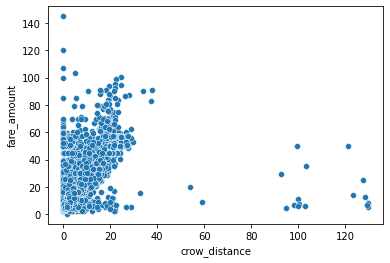

In [31]:
import seaborn as sns
sns.scatterplot(x = sdf_train.select('crow_distance').toPandas()['crow_distance'], 
                y = sdf_train.select('fare_amount').toPandas()['fare_amount'] )

<AxesSubplot:>

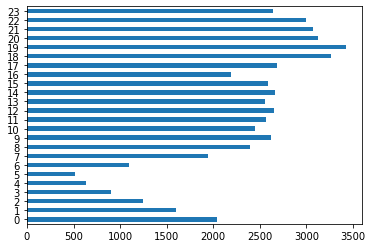

In [32]:
sdf_train.select('pickup_hour').toPandas()['pickup_hour'].value_counts().sort_index().plot(kind = 'barh')

<AxesSubplot:>

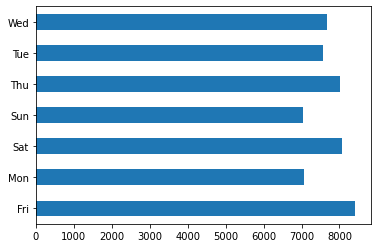

In [33]:
sdf_train.select('pickup_weekday').toPandas()['pickup_weekday'].value_counts().sort_index().plot(kind = 'barh')

<AxesSubplot:>

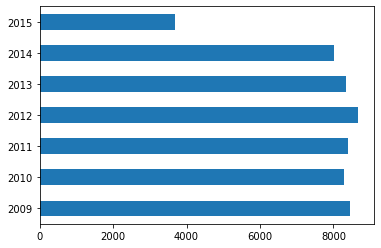

In [34]:
sdf_train.select('pickup_year').toPandas()['pickup_year'].value_counts().sort_index().plot(kind = 'barh')

# 4. Feature Selection

In [35]:
sdf_train.dtypes

[('key', 'string'),
 ('fare_amount', 'double'),
 ('pickup_datetime', 'string'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('diff_longitude', 'double'),
 ('diff_latitude', 'double'),
 ('crow_distance', 'double'),
 ('pickup_weekday', 'string'),
 ('pickup_hour', 'int'),
 ('pickup_year', 'int')]

In [36]:
str_features = [] 
num_features = []
for col in  sdf_train.dtypes:
    if "latitude" in col[0]:
        continue
    if "longitude" in col[0]:
        continue    
    if "key" == col[0]:
        continue    
    if "pickup_datetime" == col[0]:
        continue  
    if col[1] == 'string':
        str_features += [col[0]]
    else:
        num_features += [col[0]]

sdf_train_filter = sdf_train.select(num_features + str_features)
num_features.remove('fare_amount')

In [37]:
print(f'str_features : {str_features}')
print(f'num_features: {num_features}')

str_features : ['pickup_weekday']
num_features: ['passenger_count', 'crow_distance', 'pickup_hour', 'pickup_year']


# 5. Model selection

In [38]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer

pipeline_stages = []
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
pipeline_stages += str_indexer

assembler_input = [f for f in num_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
pipeline_stages += [feature_vector]

vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
pipeline_stages += [vect_indexer]


from pyspark.ml.regression import LinearRegression
LR = LinearRegression(featuresCol='features_indexed', 
                      labelCol= 'fare_amount',
                     maxIter=10,
                     regParam=0.3,
                     elasticNetParam=0.8)
pipeline_stages += [LR]

# 6. Test Train split 

In [39]:
trainTest = sdf_train_filter.randomSplit([0.8, 0.2])
traindf = trainTest[0]
testdf = trainTest[1]

# 6. Run Pipeline

In [40]:
%%time
from pyspark.ml.pipeline import Pipeline
ml_pipeline = Pipeline(stages=pipeline_stages)
model_lr = ml_pipeline.fit(traindf)

CPU times: user 60 ms, sys: 19.2 ms, total: 79.1 ms
Wall time: 3min 5s


# 7. Evaluation (LR)


In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol = "prediction", metricName = "rmse")
predictions = model_lr.transform(testdf)
rmse_lr = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_lr}")

Root Mean Squared Error (RMSE) on test data = 5.501154116198939


## 7.1 Evaluation (DT)

In [42]:
%%time
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer

pipeline_stages = []
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
pipeline_stages += str_indexer

assembler_input = [f for f in num_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
pipeline_stages += [feature_vector]

vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
pipeline_stages += [vect_indexer]

from pyspark.ml.regression import DecisionTreeRegressor
DTR = DecisionTreeRegressor(featuresCol='features_indexed', labelCol= 'fare_amount')
pipeline_stages += [DTR]
ml_pipeline = Pipeline(stages=pipeline_stages)
model_dt = ml_pipeline.fit(traindf)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol = "prediction", metricName = "rmse")
predictions = model_dt.transform(testdf)
rmse_dt = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_dt}")

Root Mean Squared Error (RMSE) on test data = 4.510594057202111
CPU times: user 74.3 ms, sys: 21.5 ms, total: 95.7 ms
Wall time: 2min 29s


## 7.2 Evaluation (RF)

In [43]:
%%time
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer

pipeline_stages = []
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
pipeline_stages += str_indexer

assembler_input = [f for f in num_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
pipeline_stages += [feature_vector]

vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
pipeline_stages += [vect_indexer]

from pyspark.ml.regression import RandomForestRegressor
RFR = RandomForestRegressor(featuresCol='features_indexed', labelCol='fare_amount') #0.18353
pipeline_stages += [RFR]
ml_pipeline = Pipeline(stages=pipeline_stages)
model_rf = ml_pipeline.fit(traindf)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol = "prediction", metricName = "rmse")
predictions = model_rf.transform(testdf)
rmse_rf = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_rf}")

Root Mean Squared Error (RMSE) on test data = 4.859178787577441
CPU times: user 74.4 ms, sys: 21.4 ms, total: 95.7 ms
Wall time: 2min 29s


## 7.3 Evaluation (GB)

In [44]:
%%time
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer

pipeline_stages = []
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
pipeline_stages += str_indexer

assembler_input = [f for f in num_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
pipeline_stages += [feature_vector]

vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
pipeline_stages += [vect_indexer]

from pyspark.ml.regression import GBTRegressor
GBTR = GBTRegressor(featuresCol='features_indexed', labelCol='fare_amount', maxIter =10)
pipeline_stages += [GBTR]
ml_pipeline = Pipeline(stages=pipeline_stages)
model_gb = ml_pipeline.fit(traindf)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol = "prediction", metricName = "rmse")
predictions = model_gb.transform(testdf)
rmse_gb = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_gb}")

Root Mean Squared Error (RMSE) on test data = 4.482471475797117
CPU times: user 91.4 ms, sys: 10.5 ms, total: 102 ms
Wall time: 3min 6s


# 8. Predict Kaggle test set for evaluation 

In [45]:
%%time
sdf_test = spark.read.csv(f'{DATA_PATH}/test.csv', inferSchema=True, header=True)
print((sdf_test.count(), len(sdf_test.columns)))

(9914, 7)
CPU times: user 3.13 ms, sys: 0 ns, total: 3.13 ms
Wall time: 229 ms


In [46]:
sdf_test = sdf_test.withColumn("pickup_weekday", date_format("pickup_datetime", "E"))
sdf_test = sdf_test.withColumn("pickup_hour", date_format("pickup_datetime", "H").cast("int"))
sdf_test = sdf_test.withColumn("pickup_year", date_format("pickup_datetime", "y").cast("int"))

In [47]:
sdf_test = sdf_test.withColumn('diff_longitude', abs( sdf_test['dropoff_longitude'] - sdf_test['pickup_longitude'] )*87 )
sdf_test = sdf_test.withColumn('diff_latitude', abs( sdf_test['dropoff_latitude'] - sdf_test['pickup_latitude'] )*111 )
sdf_test = sdf_test.withColumn('crow_distance', sqrt((sdf_test['diff_longitude']**2) + (sdf_test['diff_latitude']**2))  )

In [48]:
sdf_test_filter = sdf_test.select(num_features + str_features)

In [49]:
sdf_predict = model.transform(sdf_test_filter)

NameError: name 'model' is not defined

In [ ]:
sdf_predict.limit(5).toPandas().T

In [ ]:
sdf_predict.withColumnRenamed('prediction','fare_amount')\
            .select('key','fare_amount')\
            .coalesce(1)\
            .write.csv('submission',mode='overwrite',header=True)